# Lista de Exercícios 3: Aproximação de Funções

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido **antes** de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps3.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 05/06/2025. **Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.**
- ***SUBMISSÕES QUE NÃO SEGUIREM ESTAS INSTRUÇÕES NÃO SERÃO AVALIADAS.***
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Mountain Car

Mountain Car é um ambiente no qual um agente precisa conduzir um carro até o topo de uma montanha. No entanto, o motor do carro não é potente o suficiente para subir diretamente até o topo. Por isso, o agente precisa aprender a aproveitar o impulso - movendo-se para frente e para trás - para ganhar velocidade suficiente e alcançar o topo.

![](https://gymnasium.farama.org/_images/mountain_car.gif)

O espaço de observação é contínuo e composto por dois valores: a posição e a velocidade do carro. O agente pode escolher entre três ações discretas: acelerar o carro para a esquerda, acelerar para a direita, ou não acelerar. A posição inicial do agente é definida de forma uniformemente aleatória no intervalo $[-0.6, -0.4]$. O episódio se encerra quando o carro atinge o topo da montanha à direita (posição $0.5$) ou quando o limite de 200 passos é atingido. A cada passo, o agente recebe uma penalidade de $-1$, incentivando-o a alcançar o objetivo no menor número possível de passos. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Devido à natureza contínua do espaço de estados, métodos tabulares não são eficazes. Assim, é comum o uso de técnicas de aproximação de função para solucionar o problema de forma eficiente. Nesta lista de exercícios, você irá trabalhar com o ambiente Mountain Car descrito acima. Seu objetivo será implementar o algoritmo *Semi-Gradient Episodic Sarsa* com aproximação linear e explorar como diferentes técnicas de construção de features influenciam o desempenho do agente.

## Semi-Gradient Episodic Sarsa

Nesta atividade, você implementará um agente baseado no algoritmo Semi-Gradient Episodic SARSA, utilizando uma **função de valor linear**.

Antes de iniciar sua implementação, analise a interface `FeatureExtractor` fornecida abaixo. Ela será a base para os construtores de features que você implementará na próxima seção. O agente utilizará um objeto com essa interface para extrair features a partir das observações dos estados.

In [1]:
from abc import ABC, abstractmethod

import numpy as np
import gymnasium as gym
import sklearn
import matplotlib.pyplot as plt

In [2]:
class FeatureExtractor(ABC):
    """
    Interface for feature extractors that convert environment states into feature vectors.
    """

    @property
    @abstractmethod
    def feature_size(self):
        """
        Property that returns the size of the feature vector produced by this extractor.

        Returns:
            An integer representing the length of the feature vector.
        """
        pass

    @abstractmethod
    def extract(self, state):
        """
        Converts a raw state into a 1D feature vector.

        Args:
            state: The observation state from the environment.

        Returns:
            The extracted feature vector representation.
        """
        pass

Siga as instruções abaixo para implementar seu agente:

1. Implemente o método `__init__` que inicializa um novo agente. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, um construtor de features (`feature_extractor`), a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$. Inicialize os pesos do modelo na variável `self.weights`.
2. Implemente o método `compute_q_values`, que recebe um vetor de features e calcula os *Q-values* de acordo com a entrada.
3. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
4. Implemente o método `learn`, que atualiza os pesos do agente com base na experiência obtida durante a interação com o ambiente.
5. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [3]:
class SGESAgent:
    def __init__(
        self,
        observation_space,
        action_space,
        feature_extractor,
        alpha=0.01,
        gamma=0.99,
        epsilon=0.1,
    ):
        # YOUR CODE HERE
        self.observation_space = observation_space
        self.action_space = action_space
        self.feature_extractor = feature_extractor
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.weights = np.zeros((action_space.n, feature_extractor.feature_size))

    def compute_q_values(self, features):
        # YOUR CODE HERE
        return np.dot(self.weights, features)

    def choose_action(self, state):
        # YOUR CODE HERE
        features = self.feature_extractor.extract(state)

        if np.random.random() < self.epsilon:
            return self.action_space.sample()
        else:
            q_values = self.compute_q_values(features)
            return np.argmax(q_values)

    def learn(self, state, action, reward, next_state, next_action, done):
        # YOUR CODE HERE
        features = self.feature_extractor.extract(state)

        q_current = np.dot(self.weights[action], features)

        if done:
            q_target = reward
        else:
            next_features = self.feature_extractor.extract(next_state)
            q_next = np.dot(self.weights[next_action], next_features)
            q_target = reward + self.gamma * q_next

        td_error = q_target - q_current

        self.weights[action] += self.alpha * td_error * features

    def train(self, env, episodes=500):
        # YOUR CODE HERE
        rewards = []

        for e in range(episodes):
            state, _ = env.reset()
            action = self.choose_action(state)
            episode_return = 0
            done = False

            while not done:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                episode_return += reward

                if not done:
                    next_action = self.choose_action(next_state)

                    self.learn(state, action, reward, next_state, next_action, done)

                    state = next_state
                    action = next_action

                else:
                    self.learn(state, action, reward, next_state, None, done)

            rewards.append(episode_return)

        return rewards


In [4]:
# Não altere ou remova esta célula

In [5]:
# Não altere ou remova esta célula

In [6]:
# Não altere ou remova esta célula

In [7]:
# Não altere ou remova esta célula

In [8]:
# Não altere ou remova esta célula

## Construção de Features

Com o algoritmo do agente pronto, você deverá implementar 3 modelos de construtores de features diferentes:

1. **Modelo Identidade**
2. **Modelo Tile Coding**
3. **Modelo de Funções de Base Radial**

### Identidade

6. Implemente o `IdentityFeatureExtractor`, cujo método `extract` apenas retorna a observação de entrada, sem realizar nenhuma operação nela.

In [9]:
class IdentityFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space):
        # YOUR CODE HERE
        self.observation_space = observation_space
        (self._feature_size,) = observation_space.shape

    @property
    def feature_size(self):
        # YOUR CODE HERE
        return self._feature_size

    def extract(self, state):
        # YOUR CODE HERE
        return np.array(state)

In [10]:
# Não altere ou remova esta célula

7. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `IdentityFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `identity_agent`.

In [11]:
env = gym.make("MountainCar-v0")

# YOUR CODE HERE
identity_semi_gradient_episodic_sarsa_agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=IdentityFeatureExtractor(env.observation_space),
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
)

identity_agent = identity_semi_gradient_episodic_sarsa_agent.train(env, episodes=2000)

env.close()

In [12]:
# Não altere ou remova esta célula

### Tile Coding

8. Implemente o `TileCodingFeatureExtractor`, cujo método `extract` gera um vetor de features utilizando a técnica de *tile coding*. A quantidade de tilings a ser gerada é definida pelo parâmetro `num_tilings`, enquanto a quantidade de divisões por dimensão em cada tiling é definida pelo parâmetro `tiles_per_dim`. Ambos valores são fornecidos ao construtor da classe. Por exemplo: um `TileCodingFeatureExtractor` com `num_tilings = 3` e `tiles_per_dim = 2` deve gerar 3 tilings, cada um dividindo o espaço em uma grade de tamanho 2$\times$2.

**Importante:** Após a implementação, realize experimentos variando os valores de `num_tilings` e `tiles_per_dim` para identificar as configurações que resultam em melhor desempenho de aprendizado.

In [13]:
class TileCodingFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, num_tilings, tiles_per_dim):
        # YOUR CODE HERE
        self.observation_space = observation_space
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim

        self.low = observation_space.low
        self.high = observation_space.high
        self.dims = len(self.low)

        self.tiles_per_tiling = tiles_per_dim**self.dims

        self._feature_size = self.num_tilings * self.tiles_per_tiling

        self.offsets = np.array(
            [
                [
                    (i / num_tilings) * (self.high[dim] - self.low[dim]) / tiles_per_dim
                    for dim in range(self.dims)
                ]
                for i in range(num_tilings)
            ]
        )

    @property
    def feature_size(self):
        # YOUR CODE HERE
        return self._feature_size

    def extract(self, state):
        # YOUR CODE HERE
        state = np.array(state)
        features = np.zeros(self._feature_size)

        for tiling_idx in range(self.num_tilings):
            offset_state = state + self.offsets[tiling_idx]

            tile_indices = []

            for dim in range(self.dims):
                normalized = (offset_state[dim] - self.low[dim]) / (
                    self.high[dim] - self.low[dim]
                )
                tile_idx = int(normalized * self.tiles_per_dim)
                tile_idx = np.clip(tile_idx, 0, self.tiles_per_dim - 1)
                tile_indices.append(tile_idx)

            single_tile_idx = 0
            multiplier = 1
            for dim in range(self.dims):
                single_tile_idx += tile_indices[dim] * multiplier
                multiplier *= self.tiles_per_dim

            feature_idx = tiling_idx * self.tiles_per_tiling + single_tile_idx
            features[feature_idx] = 1.0

        return features

In [14]:
# Não altere ou remova esta célula

9. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `TileCodingFeatureExtractor` com `num_tilings = 6` e `tiles_per_dim = 6`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `tile_agent`.

In [15]:
env = gym.make("MountainCar-v0")

# YOUR CODE HERE
tile_coding_semi_gradient_episodic_sarsa_agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=TileCodingFeatureExtractor(
        observation_space=env.observation_space, num_tilings=6, tiles_per_dim=6
    ),
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
)

tile_agent = tile_coding_semi_gradient_episodic_sarsa_agent.train(env, episodes=2000)

env.close()

In [16]:
# Não altere ou remova esta célula

### Funções de Base Radial

10. Implemente o `RBFFeatureExtractor`, cujo método `extract` gera um conjunto de features baseadas em *Radial Basis Functions*. A quantidade total de componentes a ser gerada é definida pelo parâmetro `n_components`, fornecido ao construtor da classe. Utilize a biblioteca *scikit-learn* (sklearn) para auxiliar sua implementação.

**Importante:** Você pode combinar RBFs com diferentes parâmetros para capturar melhor dinâmicas complexas do ambiente e potencialmente melhorar o desempenho do agente. Após a implementação, realize experimentos variando essas configurações para identificar as combinações que produzem os melhores resultados de aprendizado. Normalizar o vetor de entrada também pode facilitar o aprendizado.

In [17]:
class RBFFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, n_components):
        # YOUR CODE HERE
        self.observation_space = observation_space
        self.n_components = n_components
        self._feature_size = n_components

        self.low = observation_space.low
        self.high = observation_space.high

        self.scaler = sklearn.preprocessing.StandardScaler()

        self.rbf_sampler = sklearn.kernel_approximation.RBFSampler(
            n_components=n_components, gamma=1.0, random_state=42
        )

        n_samples = 1000

        sample_positions = np.linspace(
            self.low[0], self.high[0], int(np.sqrt(n_samples))
        )
        sample_velocities = np.linspace(
            self.low[1], self.high[1], int(np.sqrt(n_samples))
        )

        pos_grid, vel_grid = np.meshgrid(sample_positions, sample_velocities)
        sample_states = np.column_stack([pos_grid.ravel(), vel_grid.ravel()])

        self.scaler.fit(sample_states)

        normalized_samples = self.scaler.transform(sample_states)
        self.rbf_sampler.fit(normalized_samples)

    @property
    def feature_size(self):
        # YOUR CODE HERE
        return self._feature_size

    def extract(self, state):
        # YOUR CODE HERE
        state = np.array(state).reshape(1, -1)

        normalized_state = self.scaler.transform(state)

        rbf_features = self.rbf_sampler.transform(normalized_state)

        return rbf_features.flatten()

In [18]:
# Não altere ou remova esta célula

11. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `RBFFeatureExtractor` com 100 componentes. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `rbf_agent`.

In [19]:
env = gym.make("MountainCar-v0")

# YOUR CODE HERE
rbf_semi_gradient_episodic_sarsa_agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=RBFFeatureExtractor(
        observation_space=env.observation_space, n_components=100
    ),
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
)

rbf_agent = rbf_semi_gradient_episodic_sarsa_agent.train(env, episodes=2000)

env.close()

In [20]:
# Não altere ou remova esta célula

## Análise

12. Utilize a biblioteca matplotlib para construir um gráfico comparativo dos retornos episódicos obtidos pelos agentes utilizando cada um dos construtores de features implementados. Utilize as variáveis `null_agent`, `poly_agent` e `rbf_agent` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Caso seja necessário, aplique uma média movel para suavizar as curvas e deixar as tendências mais evidentes. Inclua título, legendas e rótulos de eixos apropriados para facilitar a interpretação. Se utilizar algum tipo de suavização, indique claramente no gráfico qual o método aplicado.

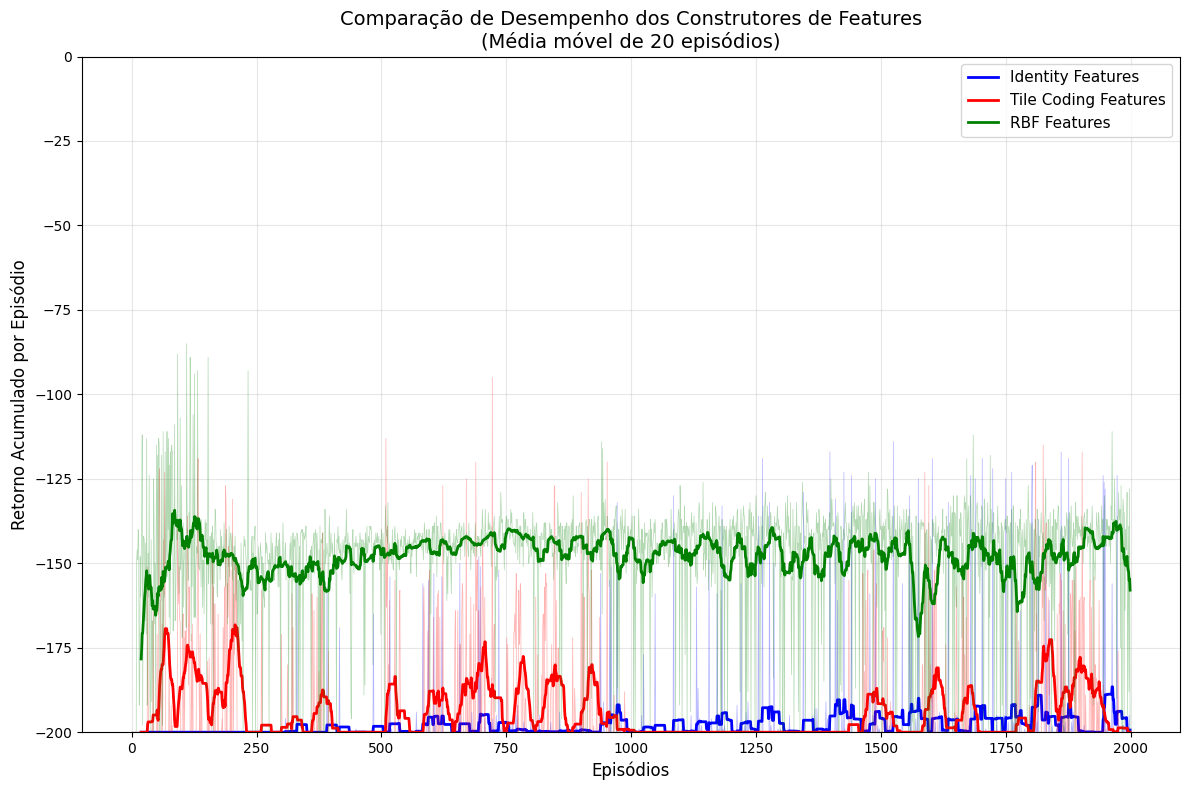

Resumo do Desempenho (últimos 50 episódios):
--------------------------------------------------
Identity Features - Média: -197.2
Tile Coding Features - Média: -199.5
RBF Features - Média: -146.8


In [21]:
# YOUR CODE HERE
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 8))

window_size = 20

# identity
episodes = range(len(identity_agent))
plt.plot(episodes, identity_agent, alpha=0.3, color='blue', linewidth=0.5)
smoothed = moving_average(identity_agent, window_size)
smoothed_episodes = range(window_size-1, len(identity_agent))
plt.plot(smoothed_episodes, smoothed, color='blue', linewidth=2, label='Identity Features')

# tile
episodes = range(len(tile_agent))
plt.plot(episodes, tile_agent, alpha=0.3, color='red', linewidth=0.5)
smoothed = moving_average(tile_agent, window_size)
smoothed_episodes = range(window_size-1, len(tile_agent))
plt.plot(smoothed_episodes, smoothed, color='red', linewidth=2, label='Tile Coding Features')

# rbf
episodes = range(len(rbf_agent))
plt.plot(episodes, rbf_agent, alpha=0.3, color='green', linewidth=0.5)
smoothed = moving_average(rbf_agent, window_size)
smoothed_episodes = range(window_size-1, len(rbf_agent))
plt.plot(smoothed_episodes, smoothed, color='green', linewidth=2, label='RBF Features')


plt.xlabel('Episódios', fontsize=12)
plt.ylabel('Retorno Acumulado por Episódio', fontsize=12)
plt.title(f'Comparação de Desempenho dos Construtores de Features\n(Média móvel de {window_size} episódios)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(-200, 0)
plt.tight_layout()
plt.show()

print("Resumo do Desempenho (últimos 50 episódios):")
print("-" * 50)
print(f"Identity Features - Média: {np.mean(identity_agent[-50:]):.1f}")
print(f"Tile Coding Features - Média: {np.mean(tile_agent[-50:]):.1f}")
print(f"RBF Features - Média: {np.mean(rbf_agent[-50:]):.1f}")


13. Explique por que a modelagem do construtor de features pode ser crucial para o desempenho de um agente que utiliza aproximação de função.

YOUR ANSWER HERE

14. Quais critérios devem guiar a escolha dos modelos e da quantidade de features a serem utilizadas na construção do espaço de features?

YOUR ANSWER HERE